In [ ]:
!pip install deterministic-rsa-keygen

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We can generate a key deterministically from a textual secret (which could be a set of unique features from a face and phone interaction)


In [ ]:
from rsa import generate_key, encrypt, decrypt

# as alternatives you can use a bit39 phrase or another key as seed
secret_key = generate_key("the derived key cannot be stronger than this seed")

private_key = secret_key.exportKey("PEM")
public_key = secret_key.publickey().exportKey("PEM")

(public_key, private_key)

# eg round trip:
secret = encrypt("secret", public_key)
assert decrypt(secret, private_key) == bytes("secret", 'utf-8')



Some terribly rudimentary face detection:


In [ ]:
!pip install mtcnn
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


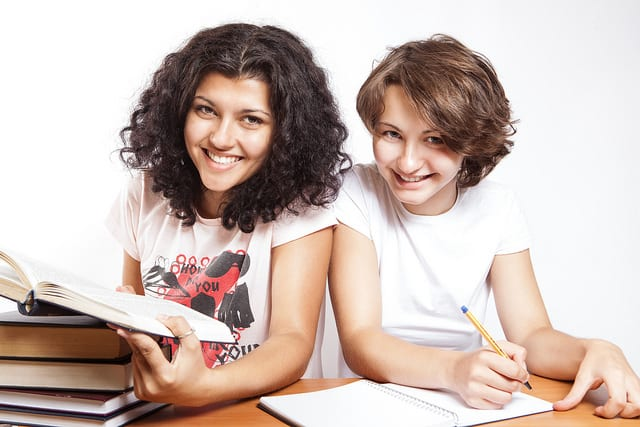

In [ ]:

# confirm mtcnn was installed correctly
import mtcnn
# print version
print(mtcnn.__version__)

# face detection with mtcnn on a photograph
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN
# load image from file
pixels = pyplot.imread("sample_data/test1.jpg")

# create the detector, using default weights
detector = MTCNN()

# detect faces in the image
faces = detector.detect_faces(pixels)
for face in faces:
	print(face)

0.1.0
1/1 [==============================] - 0s 178ms/step
{'box': [373, 83, 100, 129], 'confidence': 0.9998095035552979, 'keypoints': {'left_eye': (392, 132), 'right_eye': (436, 139), 'nose': (403, 171), 'mouth_left': (390, 171), 'mouth_right': (438, 177)}}
{'box': [185, 68, 91, 118], 'confidence': 0.9993303418159485, 'keypoints': {'left_eye': (208, 110), 'right_eye': (252, 119), 'nose': (220, 143), 'mouth_left': (200, 148), 'mouth_right': (245, 159)}}


The sample image I has 2 faces, but lets take the first one:

In [ ]:
face = faces[0]
face


{'box': [373, 83, 100, 129],
 'confidence': 0.9998095035552979,
 'keypoints': {'left_eye': (392, 132),
  'right_eye': (436, 139),
  'nose': (403, 171),
  'mouth_left': (390, 171),
  'mouth_right': (438, 177)}}

In [ ]:
secret_key = generate_key(str(face))

private_key = secret_key.exportKey("PEM")
public_key = secret_key.publickey().exportKey("PEM")

(public_key, private_key)

# eg round trip:
secret = encrypt("Hello World", public_key)
assert decrypt(secret, private_key) == bytes("Hello World", 'utf-8')

What we really want to do is put the face dimensions in a large vector space and get one number we can use as the seed - we can round things down on the way so that it is "close" even with differing values from the picture (borrowed from https://stackabuse.com/guide-to-multidimensional-scaling-in-python-with-scikit-learn/)

In [ ]:
def face_to_stress(face):
  from sklearn.manifold import MDS
  from matplotlib import pyplot as plt
  import sklearn.datasets as dt
  import seaborn as sns         
  import numpy as np
  from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
  from matplotlib.offsetbox import OffsetImage, AnnotationBbox



  """

  {'box': [373, 83, 100, 129],
  'confidence': 0.9998095035552979,
  'keypoints': {'left_eye': (392, 132),
    'right_eye': (436, 139),
    'nose': (403, 171),
    'mouth_left': (390, 171),
    'mouth_right': (438, 177)}}

  """


  x_offset = face['box'][0]
  y_offset = face['box'][1]



  def round_ten(num):    
    return round(num/10)*10

  (left_eye_1, left_eye_2) = face['keypoints']['left_eye'] 
  (right_eye_1, right_eye_2) = face['keypoints']['right_eye']
  (nose_1, nose_2) = face['keypoints']['nose']
  (mouth_left_1, mouth_left_2) = face['keypoints']['mouth_left']
  (mouth_right_1, mouth_right_2) = face['keypoints']['mouth_right']

  X = np.array([[round_ten(left_eye_1-x_offset), round_ten(left_eye_2-y_offset)], 
                [round_ten(right_eye_1-x_offset), round_ten(right_eye_2-y_offset)], 
                [round_ten(nose_1-x_offset), round_ten(nose_2-y_offset)], 
                [round_ten(mouth_left_1-x_offset), round_ten(mouth_left_2-y_offset)], 
                [round_ten(mouth_right_1-x_offset), round_ten(mouth_right_2-y_offset)]])
  mds = MDS(random_state=0)
  X_transform = mds.fit_transform(X)

  stress = mds.stress_
  print(stress)

stress = face_to_stress(face)  


0.07707175558959707


We can use stress as the key from an approximate face:


In [ ]:
secret_key = generate_key(str(stress))

public_key = secret_key.publickey().exportKey("PEM")

# eg round trip:
secret = encrypt("Hello World using face as key", public_key)

print(secret)

b'jjOeMdCyG11hp5xtPN8bhs0mzskgzQZMTKhvgoq196Aaud4BaKH5u5/TCzA/eteSCQHrcS/mtM+tO+63t/if95D3NVf/zR+zUI12/xN/FVSmNzt2oaYv0pSWbV2VemVAQWdEYXbsl8TyVmFlXzsTlj5+D9sIIqthcbnfqLZJh/WhORYzg7xn00a/zFUmFrx8G4xW6Rn39vdMK/J9yWZxuzkbMuWFpKjJzbqsNpAQDKO/ObMh2Eim5o0xudevwzI/uONiRUH0sZIcqiaW2zpQ1a2YdH7UPrMrWxm13+bOa9D6SvoK7O71WFQd24DvPo2/h98+eRFI/JS1whOKeoQmtg=='



And generate it again, to get the private key to decrypt the secret:

In [ ]:
secret_key = generate_key(str(stress))

private_key = secret_key.export_key("PEM")
decrypt(secret, private_key)



b'Hello World using face as key'

But now lets try with a different picture, to see if our keypoint normalisation, rounding and dimensional flattening works. Lets load this image: 
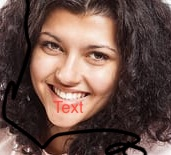

In [ ]:


# load image from file
pixels = pyplot.imread("sample_data/test2.jpg")

# create the detector, using default weights
detector = MTCNN()

# detect faces in the image
faces2 = detector.detect_faces(pixels)
for face in faces2:
	print(face)

1/1 [==============================] - 0s 141ms/step
{'box': [33, 2, 86, 119], 'confidence': 0.9998608827590942, 'keypoints': {'left_eye': (54, 45), 'right_eye': (98, 55), 'nose': (68, 80), 'mouth_left': (46, 85), 'mouth_right': (91, 95)}}


In [ ]:
stress = face_to_stress(faces2[0])

0.12541588643659957


Note that it is the same value as last time, but from a different image

In [ ]:
secret_key = generate_key(str(stress))

private_key = secret_key.export_key("PEM")
decrypt(secret, private_key)

b'Hello World using face as key'